In [37]:
from utils import *
m = Maestro()
plt.style.use(gstyle + 'dark-theme.mplstyle')

# Reading data

In [38]:
df = pd.read_csv('./data/hr-resources/hr_resources.csv')

In [39]:
# renaming columns for a better understanding
df.columns = [re.sub( '(?<!^)(?=[A-Z])', '_', x).lower() for x in df.columns.to_list()]

In [40]:
# visualizing columns dtypes
df.dtypes.value_counts()

int64     26
object     9
Name: count, dtype: int64

# Features engineering

### Numerical and categorical features

In [41]:
# drop target column
_v = df.drop(columns='attrition')
# categorical columns list
cat = _v.select_dtypes(include=['object']).columns.to_list()
# numerical columns list
num = _v.loc[:, ~_v.columns.isin(cat)].columns.to_list()

### Train/Test split

In [42]:
# dependent features, target feature
x,y = df.drop(columns='attrition'),df.attrition.map({'Yes': 1, 'No': 0})
# train/test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### Pipeline for features engineering

In [43]:
# pipeline for numerical features
num_pipe = Pipeline(
    [
        ('scaler', RobustScaler()),
    ]
)

# pipeline for categorical features
cat_pipe = Pipeline(
    [
        ('encoder', OneHotEncoder())
    ]
)

# column transformer for applying transformations only on some columns
preprocessor = ColumnTransformer(
    [
        ('Numerical features',num_pipe,num),
        ('Categorical features',cat_pipe,cat)
    ]
)

# Modelling

### Pipeline for modelling

In [44]:
# model
model = LogisticRegression()
 
# entire pipeline
pipe = Pipeline(
    [
        ('Preprocessor',preprocessor),
        ("Model", model)
    ]
)

# Model evaluation

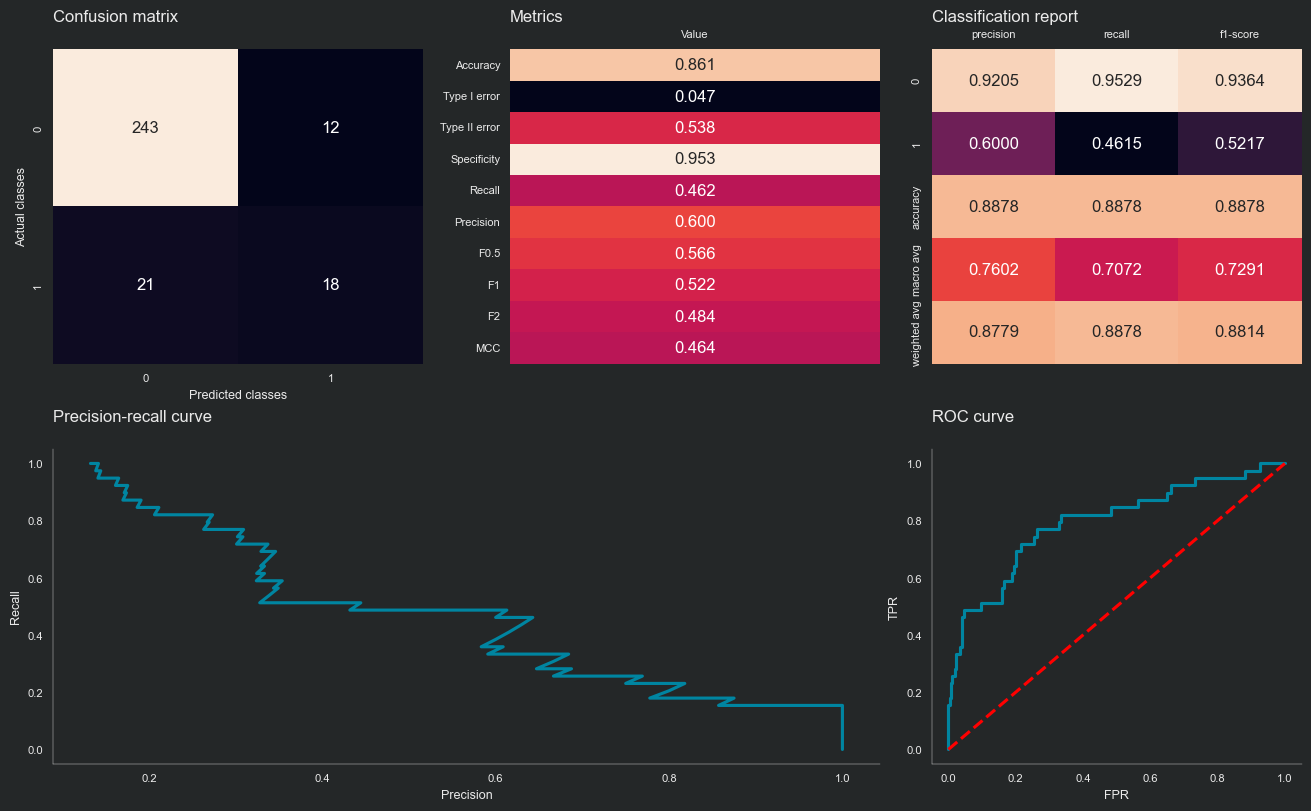

In [45]:
def classifier_diagnostic(model,x_train,y_train,x_test,y_test):
    
    
    """
    This function returns different metrics for a binary classification task.
    
    Parameters:
    -----------
    
    model: `a model object`
        Pandas dataframe object.
    x_train,y_train,x_test,y_test: `str`
        The dataframe column's name on which extracting features.

    Returns:
    data: `pandas dataframe object`
        Pandas dataframe with additional features.
    """
    
    
    # fitting the model
    model.fit(x_train,y_train) 
    # predictions
    preds = pipe.predict(x_test)
    # predicted probabilities
    pred_probs = pipe.predict_proba(x_test)[:,1]    
    
    # confusion matrix
    cm = confusion_matrix(y_test,preds)
    # roc curve
    fpr,tpr,_ = roc_curve(y_test,pred_probs)
    # precision-recall curve
    pre,rec,_ = precision_recall_curve(y_test,pred_probs)
    # classification report
    clf_report = classification_report(y_test,preds,output_dict=True)
    # true negatives, false positives, false negatives, true positives
    tn,fp,fn,tp = cm.ravel()
    
    m = {
    'Accuracy': (tp + tn) / (tp + fn + tn + fn),
    'Type I error': fp/(fp + tn),
    'Type II error': fn/(tp + fn),
    'Specificity': tn / (tn + fp),
    'Recall': tp / (tp + fn),
    'Precision': tp/ (tp + fp),
    'F0.5': fbeta_score(y_test,preds,beta=0.5),
    'F1': fbeta_score(y_test,preds,beta=1),
    'F2': fbeta_score(y_test,preds,beta=2),

    'MCC': matthews_corrcoef(y_test,preds),
    # 'Negative predictive value': tn / (tn + fn),
    # 'False discovery rate': fp / (fp + tp),
    # 'Log loss': log_loss(y_test,preds),
    # 'Average precision score': average_precision_score(y_test,preds),
    # 'AUC': roc_auc_score(y_test,preds)
    }
    
    metrics = pd.DataFrame([m],index=['Value']).T
    
    # plots layout
    fig, ax = plt.subplot_mosaic([['A', 'B','C'],['D', 'D','E']],
                                 constrained_layout=True,
                                 figsize=(13,8))
    
    # confusion matrix plot
    sns.heatmap(cm,annot=True,ax=ax['A'],fmt='.3g',cbar=False)
    ax['A'].set_title('Confusion matrix')
    ax['A'].set_xlabel('Predicted classes')
    ax['A'].set_ylabel('Actual classes')
    
    # metrics plot
    sns.heatmap(metrics,annot=True,ax=ax['B'],fmt='.3f',cbar=False)
    ax['B'].xaxis.tick_top() # x axis on top
    ax['B'].set_title('Metrics')

    # classification report plot
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax['C'],cbar=False,fmt='.4f')
    ax['C'].xaxis.tick_top() # x axis on top
    ax['C'].set_title('Classification report')
    
    # Precision-recall curve
    ax['D'].plot(pre,rec)
    ax['D'].set_title('Precision-recall curve')
    ax['D'].set_xlabel('Precision')
    ax['D'].set_ylabel('Recall')
    
    # ROC Curve
    ax['E'].plot(fpr,tpr)
    ax['E'].set_title('ROC curve')
    ax['E'].plot([0,1],[0,1],linestyle='dashed',color='red')
    ax['E'].set_xlabel('FPR')
    ax['E'].set_ylabel('TPR')
    
    plt.show()
    
    return

classifier_diagnostic(pipe,x_train,y_train,x_test,y_test)
 

## Metrics

For clarity sake we're gonna rename:

- $True \ negatives \ = tn$
- $True \ positives \ = tp$
- $False \ positives \ = fp$
- $False \ negatives \ = fn$
 
#### Accuracy
$$
Accuracy = \frac{tn + tp}{tn + tp + fp + fn}
$$

It measures how many observations, both positive and negative, were correctly classified.

#### Type I error
$$
Type \ I \ error = \frac{fp}{fp + tn}
$$

When the model predict "1" on a ground truth of "0" this is identified as Type I error.
<!-- When the cost of **"false alerts"** is high, we would want to have a low value for this metric. -->

#### Type II error
$$
Type \ I \ error = \frac{fn}{tp + fn}
$$

When the model predict "0" on a ground truth of "1" this is identified as Type II error.

#### Specificity
$$
Specificity = \frac{tn}{tn + fp}
$$

How many "0"s the model predict out of all "0" classes.
We would expect that on heavily unbalanced problem the value of $Specificity$ will be really high.

#### Recall or Sensitivity
$$
Recall = \frac{tp}{tp + fn}
$$

How many "1"s the model predict out of all "1" classes.
Technically maximizing $Recall$ metric would mean trying to minimize the number of **false negatives** 


#### Precision
$$
Precision \ = \frac{tp}{tp + fp}
$$

How many "1"s the model predict are in fact "1".
Technically maximizing $Precision$ metric would mean trying to minimize the number of **false positives** aka *false alerts*.

#### F beta score
$$
F_{beta} = (1 + \beta^{2})\frac{Precision * Recall}{(\beta^{2}*precision) + recall}
$$

The value of $\beta$ in our $F_{beta}$ score will weight how much we care about $Recall$ or $Precision$.

- $0<\beta \le 1$ gives more weight to $Precision$ over $Recall$, meaning that we care more about minimizing *false negatives*. 
- $1<\beta \le 2$ gives more weight to $Recall$ over $Precision$, meaning that we care more about minimizing *false alerts*.

#### Matthews correlation coefficient ($MCC$)
$$
MCC = \frac{(tp*tn) - (fp*fn)}{(tp + fp)(tp+fn)(tn+fp)(tn+fn)}
$$

It measures the correlation between predicted classes and ground truth.


#### Average precision




